In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy.sparse as sp
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
ddf_data = np.load('ddf_grid.npz')
ddf_grid = ddf_data['ddf_grid'].copy()

# XXX-- double check that I got this right
ack = ddf_grid['sun_alt'][0:-1] * ddf_grid['sun_alt'][1:]
night = np.zeros(ddf_grid.size, dtype=int)
night[np.where((ddf_grid['sun_alt'][1:] >=0) & (ack < 0))] += 1
night = np.cumsum(night)

In [3]:
ddf_grid

array([(59853.5       ,  0.35789797, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       (59853.51041667,  0.41360456, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       (59853.52083333,  0.46894875, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       ...,
       (63505.96874915, -0.12942338, 0.        ,  0.        ,         inf, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan),
       (63505.97916582, -0.18569237, 0.        ,  0.        ,         inf, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan),
       (63505.98958248, -0.24112162, 1.90646443, 20.87839022, 23.56106875, -9.35888477, nan, nan, -8.85712875, nan, nan, -1.36598529, nan, nan, -1.4

In [4]:
# check what the timestep is
24*60*(ddf_grid['mjd'][1] - ddf_grid['mjd'][0])

14.99999999650754

In [5]:
m = gp.Model("try_sched")

Academic license - for non-commercial use only - expires 2021-06-18
Using license file /Users/yoachim/Dropbox/Apps/Gurobi/gurobi.lic


In [6]:
ngrid = ddf_grid['mjd'].size
sun_limit = np.radians(-18.)
airmass_limit = 2.1  
sky_limit = 22.
zeropoint = 25.0  # mags
sequence_limit = 230
pause_time = 13/24.  # days
delta_t = ddf_grid['mjd'][1] - ddf_grid['mjd'][0]

# Let's try scheduling just one for now
schedule = m.addMVar(ngrid, vtype=GRB.BINARY, name="pointing_1")

# set a sun mask
sun_mask = np.zeros(ngrid, dtype=bool)
sun_mask[np.where(ddf_grid['sun_alt'] >= sun_limit)] = 1

airmass_mask = np.zeros(ngrid, dtype=bool)
airmass_mask[np.where(ddf_grid['DD:ELAISS1_airmass'] >= airmass_limit)] = 1

sky_mask = np.zeros(ngrid, dtype=bool)
sky_mask[np.where(ddf_grid['DD:ELAISS1_sky_g'] <= sky_limit)] = 1


# Let's add the constraints
m.addConstr(schedule @ sun_mask == 0)
m.addConstr(schedule @ airmass_mask == 0)
m.addConstr(schedule @ sky_mask == 0)

# limit the total number of ddf sequences
m.addConstr(schedule.sum() <= sequence_limit)


# prevent a repeat sequence in a night
unights = np.unique(night)
sched_night = m.addMVar(unights.size, vtype=GRB.CONTINUOUS)
for i,n in enumerate(unights):
    in_night = np.where(night == n)[0]
    m.addConstr(schedule[in_night]@schedule[in_night] <= 1)
    m.addConstr(sched_night[i] == schedule[in_night].sum())

In [7]:
    
# Cumulative number of scheduled events (by night, to avoid huge loop)
cumulative_sched = m.addMVar(unights.size, vtype=GRB.CONTINUOUS)
cumulative_diff = m.addMVar(unights.size, vtype=GRB.CONTINUOUS, lb=-sequence_limit, ub=sequence_limit)

cumulative_dmax = m.addMVar(unights.size, vtype=GRB.CONTINUOUS)


m.addConstr(cumulative_sched[0] == sched_night[0])

linear_cumulative = np.arange(unights.size)
linear_cumulative = linear_cumulative/np.max(linear_cumulative) * sequence_limit
m.addConstr(cumulative_diff[0] == cumulative_sched[0] - linear_cumulative[0])

for i in np.arange(1,unights.size):
    m.addConstr(cumulative_sched[i] == cumulative_sched[i-1]+sched_night[i])
    m.addConstr(cumulative_diff[i] == cumulative_sched[i] - linear_cumulative[i])
    

# Compute t_eff, something we want to maximize
t_eff = 10.**(.08*(ddf_grid['DD:ELAISS1_m5_g']-zeropoint))
t_eff[np.where(np.isnan(t_eff) == True)] = 0
t_eff[np.where(np.isinf(t_eff) == True)] = 0


In [8]:
cdiff_min = m.addMVar(1, vtype=GRB.CONTINUOUS)
cdiff_max = m.addMVar(1, vtype=GRB.CONTINUOUS)
#m.addConstr(cdiff_min == gp.min_(cumulative_diff))
#m.addConstr(cdiff_max == gp.max_(cumulative_diff))


(21.0, 23.0)

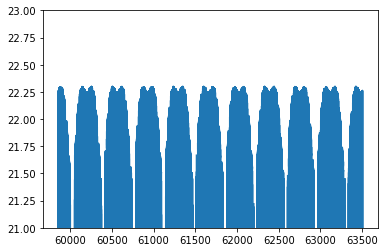

In [9]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])

In [10]:
m.setObjective(t_eff@schedule, GRB.MAXIMIZE)

In [11]:
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10963 rows, 365254 columns and 1130185 nonzeros
Model fingerprint: 0xff8066c9
Model has 3653 quadratic constraints
Variable types: 14614 continuous, 350640 integer (350640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [6e-02, 2e+02]
  QRHS range       [1e+00, 1e+00]
Presolve removed 10747 rows and 363254 columns
Presolve time: 0.84s
Presolved: 216 rows, 2000 columns, 3936 nonzeros
Variable types: 0 continuous, 2000 integer (1655 binary)
Found heuristic solution: objective 25.6180825

Root relaxation: objective 2.211231e+02, 93 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Ti

In [12]:
np.sum(m.X)
result_array = schedule.X

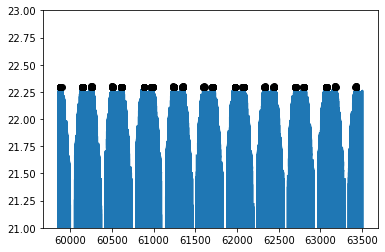

In [13]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')

(60000.0, 60500.0)

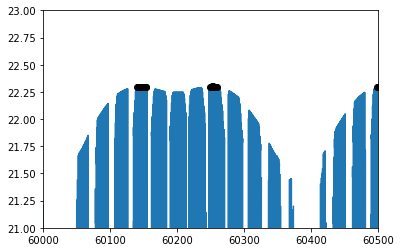

In [14]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60000, 60500)

In [15]:
night[sched]

array([  19,   20,   21,   22,   23,   24,   25,   26,   27,   41,  286,
        287,  288,  289,  290,  291,  292,  293,  294,  295,  296,  297,
        298,  299,  300,  396,  397,  398,  399,  400,  401,  402,  403,
        404,  405,  406,  645,  646,  647,  648,  649,  650,  651,  652,
        653,  654,  655,  751,  752,  753,  754,  755,  756,  757,  758,
        759,  760,  761,  762,  763,  764,  765, 1024, 1025, 1026, 1027,
       1028, 1029, 1030, 1031, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1133, 1134, 1135, 1136, 1137, 1379, 1380, 1381, 1382, 1383, 1384,
       1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1489, 1490, 1491,
       1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502,
       1741, 1742, 1743, 1744, 1745, 1746, 1747, 1762, 1846, 1847, 1848,
       1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 2118, 2119,
       2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2210, 2211, 2227,
       2228, 2229, 2230, 2231, 2232, 2233, 2473, 24

In [16]:
# can try to also optimize uniformity! Could use the KS statistic. 

# Good answer on how to do a cumulative sum here:  https://stackoverflow.com/questions/55840816/gurobi-prefix-sum-optimization

In [17]:
#m.setObjective(gp.max_(cumulative_diff), GRB.MINIMIZE)

In [18]:
cdiff_min.X

array([0.])

In [19]:
cdiff_max.X

array([0.])

In [20]:
cumulative_diff.X.min()

-9.100219058050385

In [21]:
cumulative_diff.X.max()

15.405257393209212

In [22]:
cumulative_diff.X

array([ 0.        , -0.06297919, -0.12595838, ...,  0.12595838,
        0.06297919,  0.        ])

In [23]:
linear_cumulative

array([0.00000000e+00, 6.29791895e-02, 1.25958379e-01, ...,
       2.29874042e+02, 2.29937021e+02, 2.30000000e+02])

In [24]:
gp.max_(gp.abs_(cumulative_diff))

<gurobi.GenExpr: <cyfunction Model.addGenConstrMax at 0x7f8c2f1f4c70>([<gurobi.GenExpr: <cyfunction Model.addGenConstrAbs at 0x7f8c2f1f4e10>(<(3653,) matrix variable>)>])>

In [25]:
ks_stat = m.addMVar(1, vtype=GRB.CONTINUOUS)
m.addConstr(ks_stat == gp.max_(gp.abs_(cumulative_diff[0])))
m.setObjective(ks_stat, GRB.MINIMIZE)

TypeError: bad operand type for unary -: 'GenExpr'

In [ ]:
gp.max_(gp.abs_(cumulative_diff))

# OK, I think I can trick it into making a vector that has the max of the cumulative distribution at each point. Then just us the @ opperator with a vector that has all zeros except for 1 at the final element? Sure, why not.